In [1]:
    from math import pi as pi
    from math import sqrt as sqrt
    import BondGraphTools as bgt 
    
    List = []
    with open('CircularDomain_200.cco') as f:
        for line in f:
            miniList = [elt.strip() for elt in line.split(',')]
            List.append(miniList)
    
    vesselsNum = int(List[4][0]) 
    vesselsInfo=[]
    for i in range(5,vesselsNum+5): 
        vesselsInfo.append([float(x) for x in List[i][0].split()])
    
    connectionInfo=[] 
    for i in range(406,len(List)): 
        connectionInfo.append([int(x) for x in List[i][0].split()])


In [2]:
def RCILCal(vesselsNum,vesselsInfo): # gathers all the lengths of the vessels along with their IDs as keys
    from math import pi as pi        # and calculates R, C, and I for each vessel
    from math import sqrt as sqrt
    from math import exp as exp
    
    # Constant Parameters
    bloodViscosity=0.004
    E=0.4         # Young's modulus
    bloodDensity=1050
    a=0.2802      # vessel thickness
    b=-505.3      # vessel thickness
    c=0.1324      # vessel thickness
    d=-11.14      # vessel thickness
    
    vesselLength={}; RVal={}; CVal={}; IVal={}
    for i in range(vesselsNum):  

        vesselID=int(vesselsInfo[i][0]) 
        vesselLength[vesselID]=[]
        RVal[vesselID]=[]
        CVal[vesselID]=[]
        IVal[vesselID]=[]

        x_distal=vesselsInfo[i][4]
        x_proximal=vesselsInfo[i][1]
        y_distal=vesselsInfo[i][5]
        y_proximal=vesselsInfo[i][2]
        z_distal=vesselsInfo[i][6]
        z_proximal=vesselsInfo[i][3]

        radius=vesselsInfo[i][12]

        vesselThickness=radius*(a*exp(b*radius)+c*exp(d*radius))

        vesselLength[vesselID]=(sqrt(pow((x_distal-x_proximal),2)+pow((y_distal-y_proximal),2)+pow((z_distal-z_proximal),2)))

        RVal[vesselID]=(8*bloodViscosity*vesselLength[vesselID])/(pi*pow(radius,4))

        CVal[vesselID]=(2*pi*pow(radius,3)*vesselLength[vesselID])/(vesselThickness*E)

        IVal[vesselID]=(bloodDensity*vesselLength[vesselID])/(pi*pow(radius,2))
        
    CVal[0]=CVal[0]/2

    return [RVal,CVal,IVal]

In [3]:
[RVal,CVal,IVal]=RCILCal(vesselsNum,vesselsInfo)

In [4]:
def bgComp(vesselsNum,RVal,CVal,IVal):    
    import numpy as np
    import BondGraphTools as bgt
    
    R={}; C={}; I={}; one_junc={}; zero_junc={}
    
    for v in range(vesselsNum):
        
        R[v]=[]
        C[v]=[]
        I[v]=[]
        one_junc[v]=[]
        zero_junc[v]=[]
        
        R[v]=bgt.new("R", value=RVal[v], name='R_'+str(v))
        C[v]=bgt.new("C", value=CVal[v], name='C_'+str(v))
        I[v]=bgt.new("I", value=IVal[v], name='I_'+str(v))
        
        zero_junc[v]=bgt.new("0", name='zero_junc_'+str(v))
        one_junc[v]=bgt.new("1", name='one_junc_'+str(v))
        
    return [R,C,I,one_junc,zero_junc]

In [5]:
[R,C,I,one_junc,zero_junc]=bgComp(vesselsNum,RVal,CVal,IVal)

In [6]:
def CBR_sorting(C,R,I,zero_junc,one_junc):
    # By the following appending, all the same components in each model are put together
    # So we need to separate them and gather all the components of each model in a row
    CBR=[]
    CBR.append([one_junc,zero_junc,R,I,C])  
    
    connectivity_bonds_row=[]
    for j in range(len(CBR[0][0])):
        for i in range(len(CBR[0])):
            connectivity_bonds_row.append(CBR[0][i][j])
            
    connectivity_bonds_column=connectivity_bonds_row
            
    return [connectivity_bonds_column,connectivity_bonds_row]        

In [7]:
[connectivity_bonds_column,connectivity_bonds_row]=CBR_sorting(C,R,I,zero_junc,one_junc)

In [8]:
model=bgt.new(name='Kidney Vessels')
for v in range(vesselsNum):
    bgt.add(model,R[v],C[v],I[v],one_junc[v],zero_junc[v])

In [29]:
def CM_Creation(vesselsNum):
    import numpy as np
    from copy import copy, deepcopy
    
    #  connectivity matrix for one vessel
    connectivity_matrix_v=[[0,1,1,1,0],
                           [0,0,0,0,1],
                           [0,0,0,0,0],
                           [0,0,0,0,0],
                           [0,0,0,0,0]]
    
    CM={}
    
    # Creating a dictionary with empty lists for adding the connectivity matrices for each sub-system
    for n in range(vesselsNum):
        CM[str(n)]=deepcopy(connectivity_matrix_v)
    

    Length=0
    for n in range(vesselsNum):
        Length+=len(CM[str(n)])
    connectivity_matrix_0=np.zeros((Length,Length))  

    
    k=0
    for n in range(vesselsNum):
        for i in range(k,k+len(CM[str(n)])):
            for j in range(k,k+len(CM[str(n)])):
                connectivity_matrix_0[i][j]=deepcopy(CM[str(n)][i-k][j-k])
        k+=len(CM[str(n)])
        
    return connectivity_matrix_0
                           

In [10]:
connectivity_matrix_0=CM_Creation(vesselsNum)

In [11]:
def vesselConnect(connectionInfo,connectivity_bonds_row,connectivity_matrix_0):
    import numpy as np
    from copy import copy, deepcopy
    
    Name=[]
    for i in range(len(connectionInfo)):
        if len(connectionInfo[i]) ==4:

            Name.append('zero_junc_'+str(connectionInfo[i][1]))
            Name.append('one_junc_'+str(connectionInfo[i][0]))
            
            Name.append('zero_junc_'+str(connectionInfo[i][0]))
            Name.append('one_junc_'+str(connectionInfo[i][2]))
            
            
            Name.append('zero_junc_'+str(connectionInfo[i][0]))
            Name.append('one_junc_'+str(connectionInfo[i][3]))
            
    Connection_between_models=[]
    for i in range(2,len(Name)): # first 2 elements reserved for the last connection
        for index in range(len(connectivity_bonds_row)):
                if Name[i] == connectivity_bonds_row[index].name:
                    Connection_between_models.append(index)
                    break

    connectivity_matrix=deepcopy(connectivity_matrix_0)
    for i in range(0,len(Connection_between_models),2):
        II=Connection_between_models[i]
        JJ=Connection_between_models[i+1]
        connectivity_matrix[II][JJ]=1        
    
    return [Name,connectivity_matrix]
    

In [12]:
[Name,connectivity_matrix]=vesselConnect(connectionInfo,connectivity_bonds_row,connectivity_matrix_0)

In [13]:
def BondsConnection(connectivity_matrix,connectivity_bonds_row,connectivity_bonds_column):
    import numpy as np
    import BondGraphTools as bgt
# Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivity_matrix)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivity_matrix[i][j]==1:
                bonds.append((connectivity_bonds_row[i],connectivity_bonds_column[j]))
            else:
                m=0
    
    
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)
    
    return bonds

In [14]:
bonds=BondsConnection(connectivity_matrix,connectivity_bonds_row,connectivity_bonds_column)

In [15]:
def inputConnection(model,zero_junc,one_junc):
    import numpy as np
    import BondGraphTools as bgt

    Sf=bgt.new("Sf", value=10, name='Sf_in')
    C_00=bgt.new("C", value=CVal[0], name='C_00')  #CVal[0] was previously reduced to half
    zero_junc_00=bgt.new("0", name='zero_junc_00')
    
    bgt.add(model,Sf,C_00,zero_junc_00)
    
    bgt.connect(Sf,zero_junc_00)
    bgt.connect(zero_junc_00,C_00)
    bgt.connect(zero_junc_00,one_junc[0])
    

    return model

In [16]:
model=inputConnection(model,zero_junc,one_junc)

In [28]:
def Get_Boundary(vesselsNum,bonds,model,zero_junc,one_junc):
    import BondGraphTools as bgt

    count_zero_junc={}

    for m in range(0,vesselsNum):
        itr=0

        for i in range(0,len(bonds)):
            for j in range(0,2):
                
                if bonds[i][j].name=='zero_junc_'+str(m):
                    itr += 1
                    count_zero_junc[str(m)]=itr

                    
    Se=[]; Rt=[]; It=[]; one_junc_t=[];
    i=0
    for m in range(0,vesselsNum):
        if count_zero_junc[str(m)] != 4:
            R[m].set_param('r',RVal[m]/2)
            I[m].set_param('L',IVal[m]/2)
            
            Se.append(bgt.new("Se", value=5, name='Se_'+str(m)))    
            Rt.append(bgt.new("R", value=RVal[m]/2, name='Rt_'+str(m))) # R in terminal
            It.append(bgt.new("I", value=IVal[m]/2, name='It_'+str(m))) # I in terminal
            one_junc_t.append(bgt.new("1", name='one_junc_t'+str(m)))   # 1-junc in terminal
            
            bgt.add(model,Se[i],Rt[i],It[i],one_junc_t[i])
            
            bgt.connect(zero_junc[m],one_junc_t[i])
            bgt.connect(one_junc_t[i],Rt[i])
            bgt.connect(one_junc_t[i],It[i])
            bgt.connect(Se[i],one_junc_t[i])


            i+=1

                    
    return model


In [18]:
model=Get_Boundary(vesselsNum,bonds,model,zero_junc,one_junc)

In [19]:
def combineDict(x0,vesselsNum):
    incKey = 0
    newDict = {}
    for m in range(vesselsNum):
        for val in x0:
            newDict['x_'+str(incKey)] = val
            incKey+=1
    return newDict

In [20]:
x0=[0.1]
    
x_0=combineDict(x0,len(model.state_vars))

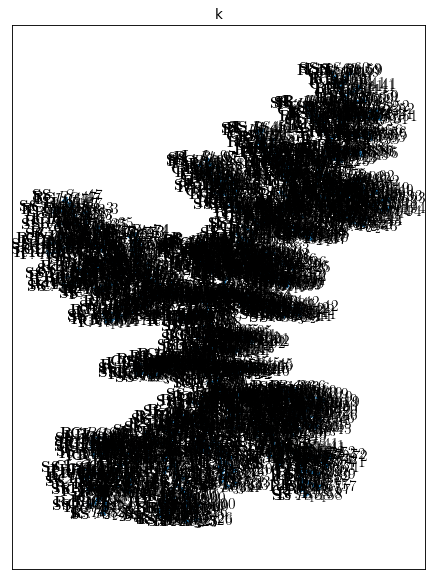

In [30]:
import BondGraphTools as bgt
bgt.draw(model)

In [ ]:
bgt.draw(model)

In [21]:
import BondGraphTools as bgt
time=[0,3000]
t, x = bgt.simulate(model, timespan=time, x0=x_0)

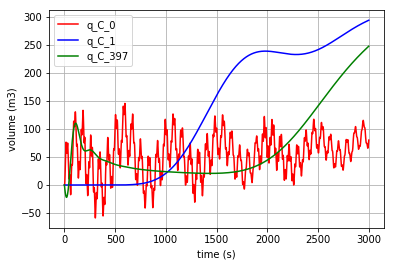

In [26]:
import matplotlib.pyplot as plt

for q, c, label in [(x[:,0],'r', 'q_C_0'), (x[:,2],'b', 'q_C_1'), (x[:,397],'g', 'q_C_397')]:
    fig=plt.plot(t,q,c, label=label)
    plt.xlabel("time (s)")
    plt.ylabel("volume (m3)") 
    plt.legend(loc='upper left')
plt.grid()

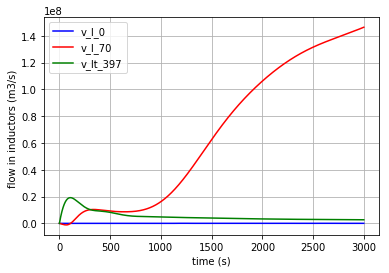

In [27]:
for p, c, label in [(IVal[0]*x[:,1],'b', 'v_I_0'), (IVal[70]*x[:,141],'r', 'v_I_70'), (IVal[397]*x[:,998],'g', 'v_It_397')]:
    fig=plt.plot(t,p,c, label=label)
    plt.xlabel("time (s)")
    plt.ylabel("flow in inductors (m3/s) ") 
    plt.legend(loc='upper left')
plt.grid()